# wOBA Prediction Model Using Data From 2015-2021

The following notebook uses code, ideas, and strategies from other programmers who are credited at the bottom of this notebook.

The data I used comes from a custom leaderboad I made on FanGraphs. It contains statistics that I believe are a good prediction of wOBA. They can be broken down into three categories: plate discipline, raw power, and bat to ball skills.


In [18]:
# Load packagess
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings(action='ignore')

# Read data and save features and target to X and y variables
data = pd.read_csv('Updated wOBA data.csv')
X = data.drop(['Name', 'Team', 'playerid', 'wOBA', 'SLG', 'OBP', 'PA'], axis=1)
y = data['wOBA']

# Step 1: Building a Model to Find Feature Importance

I used a XGBRegression Model simply because it is the model Koby uses in his workbook I credit in my sources at the bottom of the notebook. When I used a Random Forest Regression, the mae at the end was slighly higher and recomended different features, so I chose to stick with the XGB model. 

After the sixth feature there is a dropoff, so I chose the top six variables as my features.

In [19]:
# Creates an XGBRegressor with same parameters as Koby (credited at bottom) to find the best features to use for real model 
model = XGBRegressor(learning_rate=0.1, n_estimators=1000, max_depth=3, subsample=0.8)
model.fit(X, y)

# Data Frame that contains the features of the data and their respective importance 
var_importances = pd.DataFrame({'Variable': X.columns, 'Importance': model.feature_importances_}).sort_values('Importance', ascending=False)

var_importances

,Variable,Importance
15,HardHit%,0.217346
16,Barrel%,0.210425
11,BB/K,0.108011
10,CSW%,0.060098
13,K%,0.051374
17,EV,0.047518
7,F-Strike%,0.035528
12,BB%,0.034530
6,Zone%,0.027669
14,Clutch,0.027413


The following code comes from a Kaggle workbook I found that optimizes for best parameters in a Random Forest regression model. This work is credited in my sources at the bottom. 

In [14]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,  

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

model2 = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = model2, param_distributions=random_grid, 
                               n_iter=100, cv=5, verbose=2, random_state=35, n_jobs=-1)

top_features = var_importances[:6]['Variable']
new_X = X[top_features]  

train_X, test_X, train_y, test_y = train_test_split(new_X, y, random_state=0)
rf_random.fit(train_X, train_y)

print ('Random grid: ', random_grid, '\n')
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random grid:  {'n_estimators': [5, 20, 50, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': True}  



Now that we have found the best possible parameters for our model. It is time for the next step. 

# Step 2: Building the Model to Predict wOBA

I use a Random Forest Regressor because I have experience using it past Kaggle courses. I know it to be more sophisticated than a Decision Tree Regressor. 

I use the optimized parameters from the cell above and fit the model to my training data. 

In [20]:
rfmodel = RandomForestRegressor(n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', max_depth=70, 
                                bootstrap=True)
rfmodel.fit(train_X, train_y)

predictions = rfmodel.predict(test_X)

max_wOBA = round(max(predictions), 3)
min_wOBA = round(min(predictions), 3)

print("Max predicted wOBA: ", max_wOBA)
print("Min predicted wOBA: ", min_wOBA)


Max predicted wOBA:  0.375
Min predicted wOBA:  0.29


# Step 3: Model Grading and Data Visualization

I used mean absolute error to grade my model because it has meaning to the metric I am trying to predict. A MAE of .01 means that my model predicts wOBA with an error of 10 points.

I used a distribution plot to show how my model's predictions are distributed versus the actual distrubition of wOBAs from the data. From the looks of it, my model has a low MAE of about 13-14 points, but it does a bad job of predicting outliers. It projects average hitters well, but below average hitters too high and above average hitters too low. Funny enough, the average of my predictions was almost spot on with the average from my data.

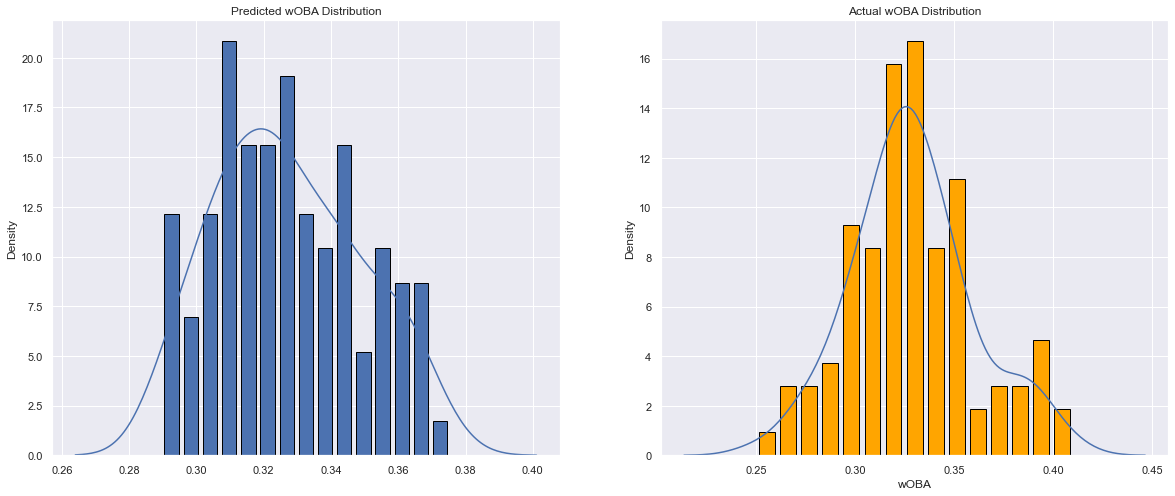

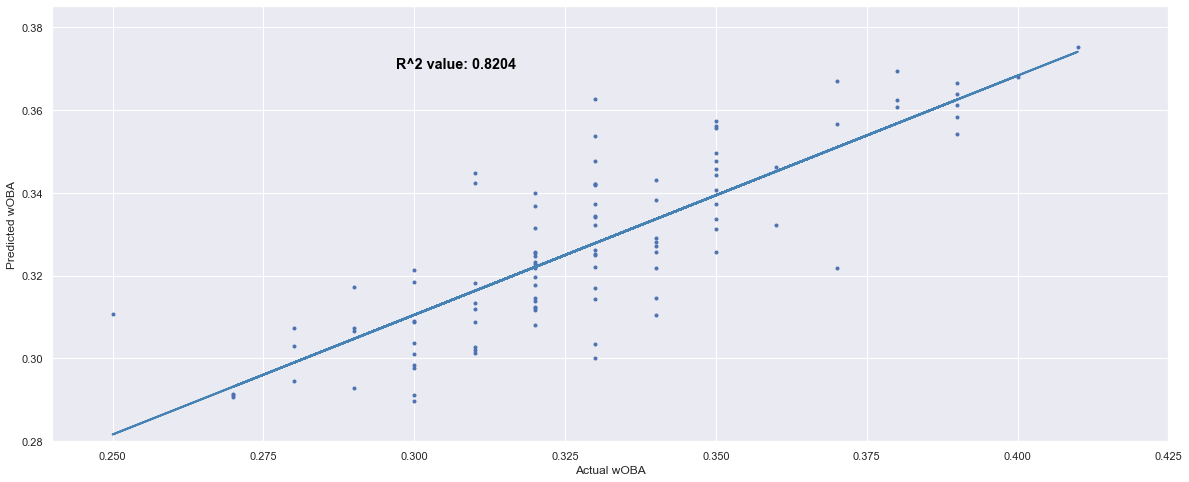

Average wOBA from 2015 - 2021:  0.326
Average out of predicted wOBAs from 2015 - 2021:  0.327

Max predicted wOBA:  0.375
Actual max wOBA:  0.43
Min predicted wOBA:  0.29
Actual min wOBA:  0.25

MAE for wOBA model:  0.01394


In [21]:
mae = mean_absolute_error(test_y, predictions)

sns.set()
sns.set(rc={'figure.figsize':(20, 8)})

fig, ax = plt.subplots(1, 2)
sns.distplot(predictions, bins=15, hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':1.0}, ax=ax[0]).set(title='Predicted wOBA Distribution')
sns.distplot(test_y, bins=15, hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':1.0, 'color':'orange'}, ax=ax[1]).set(title='Actual wOBA Distribution')

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(test_y, predictions)

plt.figure(2)
plt.plot(test_y, predictions, 'b.')
plt.xlabel('Actual wOBA')
plt.ylabel('Predicted wOBA')
a, b = np.polyfit(test_y, predictions, 1)

plt.plot(test_y, a * test_y + b, color='steelblue', linestyle='solid', linewidth=2)
plt.axis([min_wOBA-.05, max_wOBA+.05, min_wOBA-.01, max_wOBA+0.01])
plt.text(.297, .37, "R^2 value: " + str(round(r_value, 4)), horizontalalignment='left', size='large', color='black', weight='semibold')
plt.show()

avg_wOBA = 0
for wOBA in data.wOBA:
    avg_wOBA += wOBA
avg_wOBA = avg_wOBA / len(data.wOBA)

avg_wOBAp = 0
for wOBA in predictions:
    avg_wOBAp += wOBA
avg_wOBAp = avg_wOBAp / len(predictions)

max_wOBA = round(max(predictions), 3)
min_wOBA = round(min(predictions), 3)

print('Average wOBA from 2015 - 2021: ', round(avg_wOBA, 3))
print('Average out of predicted wOBAs from 2015 - 2021: ', round(avg_wOBAp, 3))
print()
print("Max predicted wOBA: ", max_wOBA)
print("Actual max wOBA: ", round(max(data.wOBA), 3))
print("Min predicted wOBA: ", min_wOBA)
print("Actual min wOBA: ", round(min(data.wOBA), 3))
print()
print("MAE for wOBA model: ", round(mae, 5))

# Conclusion

I am happy with where this project leaves off. Perhaps others can contribute and make the model better. I learned a ton from this project and I am excited to build on that newly gained knowledge on future projects. 

I utilized a ton of resources while building this project, most of which will be credited below. A lot of the syntax from the data visualization packages I had never seen or used before, so I had to look up the documentation. StackOverflow was also a big help for syntax questions. I would be lying if I said I understood all of the code 100%. I don't feel confident in my understanding of how these regression models work under the hood. My pandas skills are still in their infant stage. But I feel comfortable enough where I can build a successful model with the help of the internet. 

Take a look at my first blog on my website (kellyanalytics.weebly.com) where I build a BA prediction model days after my first Kaggle Intro to Machine Learning course and you will see why I am happy with the progress I made in this project.

Thanks for reading!

# Sources: 

https://github.com/koby-a-close/BattingAverageProjection/blob/master/BAPredictions-KobyClose.ipynb

https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=y&type=c,102,103,104,105,106,107,108,109,110,313,314,50,38,37,36,34,35,71,311,308,305,306,6&season=2021&month=0&season1=2021&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=2021-01-01&enddate=2021-12-31

https://www.kaggle.com/code/arjunprasadsarkhel/simple-random-forest-with-hyperparameter-tuning/notebook

https://stackoverflow.com/questions/893657/how-do-i-calculate-r-squared-using-python-and-numpy